In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet


In [4]:
# Load CSV file
data = pd.read_csv('/content/housing.csv')
num_columns = data.shape[1]
data.columns = [f"feature {i+1}" for i in range(num_columns)]

# View the first few rows
data.head()

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11,feature 12,feature 13,feature 14
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7


In [5]:
# Drop rows with missing values
data = data.dropna()

# Drop duplicates
data = data.drop_duplicates()

# Encode string (categorical) features
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Feature scaling (only numeric columns)
scaler = StandardScaler()
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [6]:
# Convert to numpy
data_np = data.to_numpy()


X = data_np[:35, [5,10,12]]
y = data_np[0:35, 13]

# Try different random states to find best R2 score
best_r2 = -np.inf
best_state = None

for rs in range(1, 101):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
    model = LinearRegression()
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    if r2 > best_r2:
        best_r2 = r2
        best_state = rs

print(f"Best Random State: {best_state} with R2 Score: {best_r2:.4f}")



Best Random State: 48 with R2 Score: 0.9654


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)


In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict
y_pred_lin = lin_reg.predict(X_test)




In [9]:


# Use best random state from earlier step
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=best_state)

best_degree = 1
best_r2_poly = -np.inf

for degree in range(1, 11):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    if r2 > best_r2_poly:
        best_r2_poly = r2
        best_degree = degree

print(f"Best Polynomial Degree: {best_degree} with R2 Score: {best_r2_poly:.4f}")


Best Polynomial Degree: 1 with R2 Score: 0.9654


In [10]:
poly_features = PolynomialFeatures(degree=best_degree)

X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)


In [12]:
# Polynomial Regression (no regularization)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Predictions
y_train_poly_pred = poly_model.predict(X_train_poly)
y_test_poly_pred = poly_model.predict(X_test_poly)

# Print Train and Test R² scores before regularization
print("Polynomial Regression (Degree={}):".format(best_degree))
print("Train R²:", r2_score(y_train, y_train_poly_pred))
print("Test R²:", r2_score(y_test, y_test_poly_pred))


Polynomial Regression (Degree=1):
Train R²: 0.7130809792653057
Test R²: 0.9654299525910258


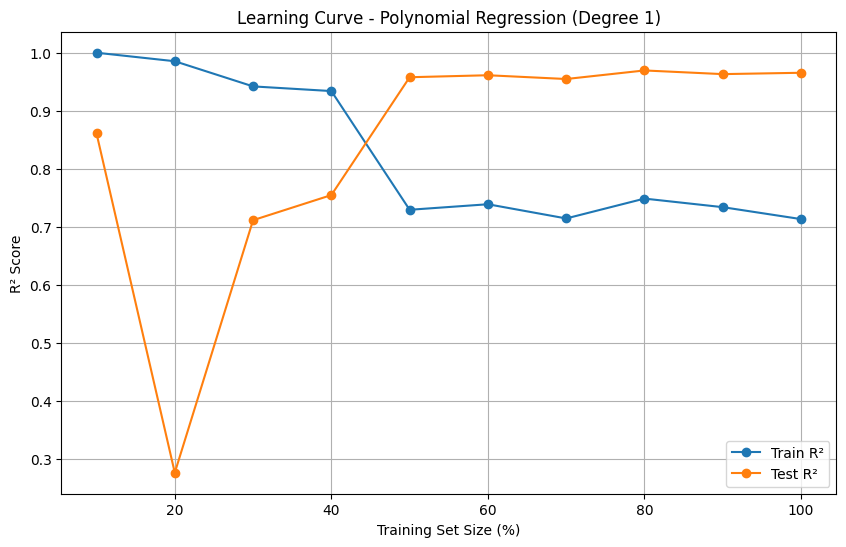

In [14]:
# Learning Curve for Polynomial Regression
train_sizes = np.linspace(0.1, 1.0, 10)
train_r2_poly = []
test_r2_poly = []

for size in train_sizes:
    n_train = int(size * len(X_train_poly))
    poly_model_partial = LinearRegression()
    poly_model_partial.fit(X_train_poly[:n_train], y_train[:n_train])

    y_train_partial_pred = poly_model_partial.predict(X_train_poly[:n_train])
    y_test_partial_pred = poly_model_partial.predict(X_test_poly)

    train_r2_poly.append(r2_score(y_train[:n_train], y_train_partial_pred))
    test_r2_poly.append(r2_score(y_test, y_test_partial_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * 100, train_r2_poly, marker='o', label='Train R²')
plt.plot(train_sizes * 100, test_r2_poly, marker='o', label='Test R²')
plt.xlabel('Training Set Size (%)')
plt.ylabel('R² Score')
plt.title(f'Learning Curve - Polynomial Regression (Degree {best_degree})')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

best_alpha = None
best_r2 = -np.inf

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_poly, y_train)
    y_test_pred = ridge.predict(X_test_poly)
    score = r2_score(y_test, y_test_pred)
    print(f"Alpha: {alpha}, Test R²: {score:.4f}")
    if score > best_r2:
        best_r2 = score
        best_alpha = alpha

print(f"\nBest alpha: {best_alpha} with Test R²: {best_r2:.4f}")


Alpha: 0.0001, Test R²: 0.9654
Alpha: 0.001, Test R²: 0.9654
Alpha: 0.01, Test R²: 0.9654
Alpha: 0.1, Test R²: 0.9647
Alpha: 1, Test R²: 0.9563
Alpha: 10, Test R²: 0.8199
Alpha: 100, Test R²: 0.2546

Best alpha: 0.0001 with Test R²: 0.9654



Ridge Regression:
Train R2: 0.7131
Test R2: 0.9654
Test MSE: 0.0223

Lasso Regression:
Train R2: 0.7119
Test R2: 0.9587
Test MSE: 0.0265

ElasticNet Regression:
Train R2: 0.7125
Test R2: 0.9612
Test MSE: 0.0249


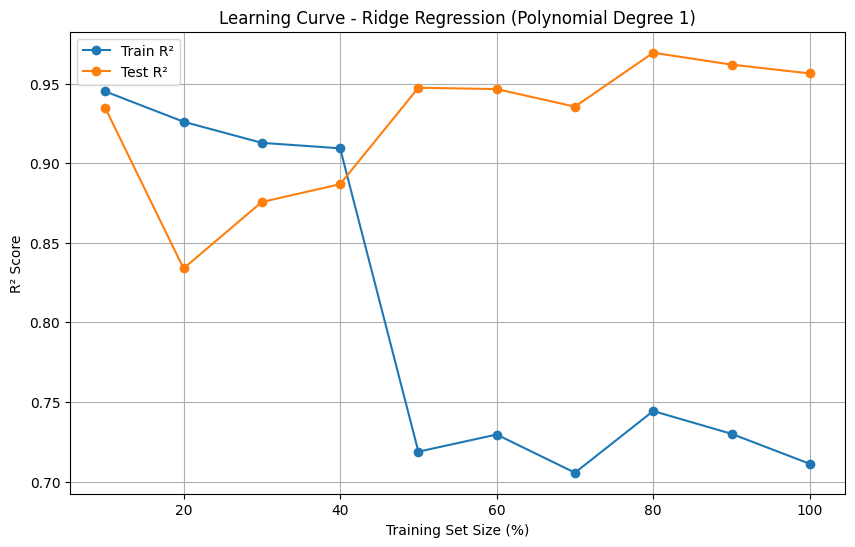

In [17]:

# Ridge Regression
ridge = Ridge(alpha=0.01)
ridge.fit(X_train_poly, y_train)
y_train_ridge_pred = ridge.predict(X_train_poly)
y_test_ridge_pred = ridge.predict(X_test_poly)

ridge_train_r2 = r2_score(y_train, y_train_ridge_pred)
ridge_test_r2 = r2_score(y_test, y_test_ridge_pred)
ridge_test_mse = mean_squared_error(y_test, y_test_ridge_pred)

print("\nRidge Regression:")
print(f"Train R2: {ridge_train_r2:.4f}")
print(f"Test R2: {ridge_test_r2:.4f}")
print(f"Test MSE: {ridge_test_mse:.4f}")

# Lasso Regression
lasso = Lasso(alpha=0.01, max_iter=10000)
lasso.fit(X_train_poly, y_train)
y_train_lasso_pred = lasso.predict(X_train_poly)
y_test_lasso_pred = lasso.predict(X_test_poly)

lasso_train_r2 = r2_score(y_train, y_train_lasso_pred)
lasso_test_r2 = r2_score(y_test, y_test_lasso_pred)
lasso_test_mse = mean_squared_error(y_test, y_test_lasso_pred)

print("\nLasso Regression:")
print(f"Train R2: {lasso_train_r2:.4f}")
print(f"Test R2: {lasso_test_r2:.4f}")
print(f"Test MSE: {lasso_test_mse:.4f}")

# ElasticNet Regression
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
elastic.fit(X_train_poly, y_train)
y_train_elastic_pred = elastic.predict(X_train_poly)
y_test_elastic_pred = elastic.predict(X_test_poly)

elastic_train_r2 = r2_score(y_train, y_train_elastic_pred)
elastic_test_r2 = r2_score(y_test, y_test_elastic_pred)
elastic_test_mse = mean_squared_error(y_test, y_test_elastic_pred)

print("\nElasticNet Regression:")
print(f"Train R2: {elastic_train_r2:.4f}")
print(f"Test R2: {elastic_test_r2:.4f}")
print(f"Test MSE: {elastic_test_mse:.4f}")


# Learning Curve for Ridge Regression (using R2)
train_sizes = np.linspace(0.1, 1.0, 10)
train_r2_scores = []
test_r2_scores = []

for size in train_sizes:
    n_train = int(size * len(X_train_poly))
    ridge_partial = Ridge(alpha=1.0)
    ridge_partial.fit(X_train_poly[:n_train], y_train[:n_train])

    y_train_partial_pred = ridge_partial.predict(X_train_poly[:n_train])
    y_test_partial_pred = ridge_partial.predict(X_test_poly)

    train_r2_scores.append(r2_score(y_train[:n_train], y_train_partial_pred))
    test_r2_scores.append(r2_score(y_test, y_test_partial_pred))

plt.figure(figsize=(10,6))
plt.plot(train_sizes * 100, train_r2_scores, marker='o', label='Train R²')
plt.plot(train_sizes * 100, test_r2_scores, marker='o', label='Test R²')
plt.xlabel('Training Set Size (%)')
plt.ylabel('R² Score')
plt.title('Learning Curve - Ridge Regression (Polynomial Degree {})'.format(best_degree))
plt.legend()
plt.grid(True)
plt.show()
